In [20]:
import pandas as pd
import numpy as np
import cvxpy as cp

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [21]:
input_dir = '/content/drive/MyDrive/인연준/금융데이터분석/input/'

## Load raw data
- 간단하게 앞쪽 10개의 asset만 가지고 

In [22]:
all_df = pd.read_csv(input_dir + 'all_asset.csv').set_index('Date').dropna(axis=1)
all_df_ret = all_df.pct_change().dropna()
rand100_ret = all_df_ret.iloc[:,:100]
rand10_ret = all_df_ret.iloc[:,10:20]

## Back Test
- Test period : 2020년 8, 9, 10월
- Look Back : 6 month
- Evaluation(rebalancing) : 1 month

In [24]:
TestPeriod = 3
EvaluationPeriod = 1
NumEval = 3
LookBackPeriod = 6

In [25]:
date = pd.Series(pd.to_datetime(all_df_ret.index))
FoldMask = date.dt.month * date.dt.year
FoldMask = pd.factorize(FoldMask)[0]
FoldMask = pd.DataFrame({'month' : FoldMask}, index=all_df_ret.index)

mth_seq = np.unique(FoldMask['month'])
TestMonth = mth_seq[-TestPeriod:]
TrainMonth = [a for a in mth_seq if a not in TestMonth]

for i in range(NumEval):
  FoldMask[f'LookBack{i+1}'] = np.nan

In [26]:
for i in range(NumEval):
  Eval = FoldMask['month'] == (TrainMonth[-1] - i)
  LBK = FoldMask['month'].isin(TrainMonth[-7-i:-1-i])
  FoldMask.loc[Eval, f'LookBack{i+1}'] = 'Eval'
  FoldMask.loc[LBK, f'LookBack{i+1}'] = 'LBK'

## 10개 Asset

In [29]:
def get_weight(df, fold = 'LookBack1'):
  asset_list = df.columns
  asset_num = len(asset_list)

  lbk_df = df.copy()[FoldMask[fold] == 'LBK']
  mu_annual = lbk_df.mean() * 252
  sigma_annual = lbk_df.cov() * 252

  pfo_weight = cp.Variable(asset_num)
  objective = cp.Minimize(cp.quad_form(pfo_weight, sigma_annual))
  constraints = [cp.sum(pfo_weight) == 1,
                pfo_weight >= 0]
  problem = cp.Problem(objective, constraints)
  problem.solve(solver=cp.ECOS)
  pfo_weight = pfo_weight.value
  
  return pfo_weight, mu_annual, sigma_annual

In [30]:
for i in [1,2,3]:

  pfo_weight, mu_annual, sigma_annual = get_weight(rand10_ret, fold=f'LookBack{i}')
  
  pfo_mu = np.dot(pfo_weight, mu_annual)
  pfo_sigma = np.dot(pfo_weight,np.dot(sigma_annual, pfo_weight))

  print(f'LookBack{i} : Portfolio with 10 Asset Return : {pfo_mu:.10%}')
  print(f'LookBack{i} : Portfolio with 10 Asset volatility : {pfo_sigma:.10%}')

LookBack1 : Portfolio with 10 Asset Return : 29.9812047579%
LookBack1 : Portfolio with 10 Asset volatility : 12.7582416970%
LookBack2 : Portfolio with 10 Asset Return : 27.2741009948%
LookBack2 : Portfolio with 10 Asset volatility : 12.6749075778%
LookBack3 : Portfolio with 10 Asset Return : 27.3737894429%
LookBack3 : Portfolio with 10 Asset volatility : 12.5018840318%


## Performance Evaluation

In [31]:
for i in [1,2,3]:

  eval_df = rand10_ret.copy()[FoldMask[f'LookBack{i}'] == 'Eval']
  print(eval_df.index[0], eval_df.index[-1])
  mu_annual_eval = eval_df.mean() * 252
  sigma_annual_eval = eval_df.cov() * 252

  pfo_mu_eval = np.dot(pfo_weight, mu_annual_eval)
  pfo_sigma_eval = np.dot(pfo_weight,np.dot(sigma_annual_eval, pfo_weight))

  print(f'Evaluation{i} : Portfolio with 10 Asset Return : {pfo_mu_eval:.10%}')
  print(f'Evaluation{i} : Portfolio with 10 Asset volatility : {pfo_sigma_eval:.10%}')

2020-07-01 2020-07-31
Evaluation1 : Portfolio with 10 Asset Return : 83.5839094472%
Evaluation1 : Portfolio with 10 Asset volatility : 3.0883253127%
2020-06-01 2020-06-30
Evaluation2 : Portfolio with 10 Asset Return : 9.0384990894%
Evaluation2 : Portfolio with 10 Asset volatility : 2.4571380747%
2020-05-01 2020-05-29
Evaluation3 : Portfolio with 10 Asset Return : 29.9648729260%
Evaluation3 : Portfolio with 10 Asset volatility : 1.7011494462%


## PCA 

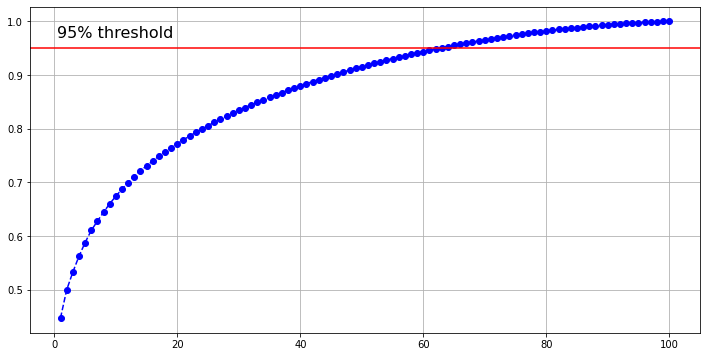

In [ ]:
pca = PCA().fit(rand100_ret.values)

x = np.arange(1, rand100_ret.shape[1]+1)
y = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(1,1, figsize=(12,6))

ax.plot(x, y, marker='o', linestyle='--', color='b')
ax.axhline(y=0.95, color='r', linestyle='-')
ax.text(0.5, 0.97, '95% threshold', fontsize=16)
ax.grid()
plt.show()

In [ ]:
N_FACTOR = 60

pca = PCA(n_components=N_FACTOR)
factor_df = pd.DataFrame(pca.fit_transform(rand100_ret), 
                         columns=[f'pca_{a+1}' for a in range(N_FACTOR)])